In [1]:
import dynamiqs as dq
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

dq.set_precision("simple")

# Get by Mesolve

In [2]:
def _one_mn_nbar_mesolve(
    lam: complex,
    alpha_2: float,
    kerr_o_kappa_2: float,
    kappa_1_o_kappa_2: float,
    nth: float,
    N: int,
):
    a = dq.destroy(N)
    L_m = a @ a + lam * dq.dag(a) @ a - alpha_2 * dq.eye(N)
    Ldn = jnp.sqrt(kappa_1_o_kappa_2*(1+nth)) * a
    Lup = jnp.sqrt(kappa_1_o_kappa_2*nth) * dq.dag(a)
    H = kerr_o_kappa_2 * dq.dag(a) @ dq.dag(a) @ a @ a

    rho_0 = dq.fock(N, 0)
    times = jnp.linspace(0, 10 / alpha_2, 101)
    output = dq.mesolve(
        H, [Lup, Ldn, L_m], rho_0, times, exp_ops=[dq.dag(a) @ a, a @ dq.dag(a) - dq.dag(a) @ a]
    )
    return output.expects[0, -1], jnp.max(jnp.abs(output.expects[1] - 1))

In [3]:
def _get_moon_nbar_mesolve(
    lam_phase: np.ndarray,
    lam_phase_offset: float,
    lam_abs: float,
    alpha_2: float,
    kerr_o_kappa_2: float = 0.0,
    kappa_1_o_kappa_2: float = 0.0,
    nth: float = 0.0,
    N: int = 100,
):
    lams = lam_abs * np.exp(1j * (lam_phase - lam_phase_offset))
    return jax.vmap(_one_mn_nbar_mesolve, in_axes=(0, None, None, None, None, None))(
        lams, alpha_2, kerr_o_kappa_2, kappa_1_o_kappa_2, nth, N
    )

In [6]:
N = 50
lam, alpha_2 = 0.5, 4
kerr_o_kappa_2 = 15 / 365
kappa_1_o_kappa_2 = 3.65/365
nth = 0.93
lambda_phase = np.linspace(-np.pi, np.pi, 31)
nbars_kerr_mesolve, commut_kerr = _get_moon_nbar_mesolve(
    lambda_phase, 0, lam, alpha_2, 0, kappa_1_o_kappa_2, nth, N
)
nbars_mesolve, commut = _get_moon_nbar_mesolve(lambda_phase, 0, lam, alpha_2, 0, 0, 0, N)

|██████████| 100.0% ◆ elapsed 01m36s ◆ remaining 0.00ms  
|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?

|██████████| 100.0% ◆ elapsed 01m33s ◆ remaining 0.00ms  
/Users/remirousseau/.pyenv/versions/3.13.0/envs/dynamiqs/lib/python3.13/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/remirousseau/.pyenv/versions/3.13.0/envs/dynamiqs/lib/python3.13/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


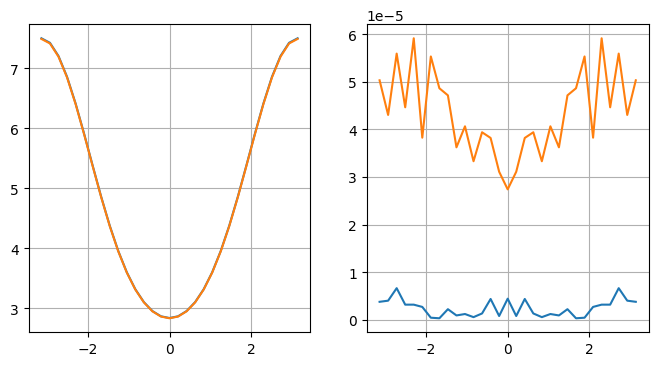

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(lambda_phase, nbars_mesolve)
ax[0].plot(lambda_phase, nbars_kerr_mesolve)
ax[0].grid()
ax[1].plot(lambda_phase, commut)
ax[1].plot(lambda_phase, commut_kerr)
ax[1].grid()